# Identify

In [19]:
from astropy.coordinates import SkyCoord
from sunpy.coordinates import RotatedSunFrame
import numpy as np

Maps :

In [20]:
from module import toSunpyMap

map_new = toSunpyMap('data/L2/imoa_03933_l2_20240323_13052647_emi1.fts.bz2')

# get previous image
map_old = toSunpyMap('data/L2/imoa_03933_l2_20240319_15102678_emi1.fts.bz2')

Labels :

In [21]:
from module import save_current_index

save_current_index(0)

In [22]:

from module import get_new_id, groupSunspots

table_old = groupSunspots(map_old)

for line in table_old:
    line['id'] = get_new_id()

table_old

label,id,noaa,longitude,latitude,x,y
,,,deg,deg,pix,pix
uint16,int32,int32,float64,float64,float64,float64
1,1,--,47.910364882296065,-21.582977237049494,1653.0,761.0
2,2,--,-58.12987179931832,-11.540141373827801,266.0,901.0
3,3,--,42.72138029310863,2.4594261011521152,1642.0,1145.0
4,4,--,-50.02757235241654,16.925268235266657,356.0,1356.0


In [23]:
table_new = groupSunspots(map_new)

table_new

label,id,noaa,longitude,latitude,x,y
,,,deg,deg,pix,pix
uint16,int32,int32,float64,float64,float64,float64
1,--,--,-4.88660115186741,-12.293311731656633,947.0,937.0
2,--,--,-36.75322491636314,-13.41099073683338,486.0,898.0
3,--,--,33.71037129690126,16.4071671618727,1516.0,1372.0
4,--,--,1.6130140579607994,16.191558481204446,1049.0,1387.0
5,--,--,-35.82716289623113,18.795738625148108,512.0,1405.0


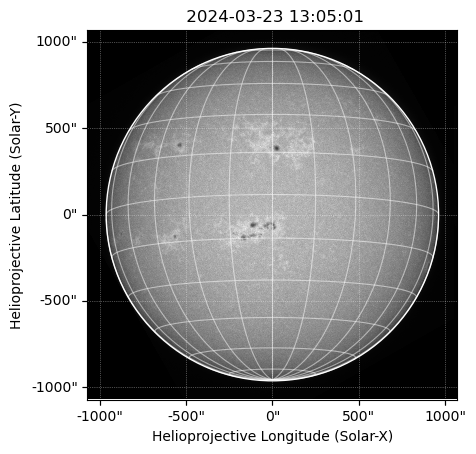

In [24]:
map_new.plot()
map_new.draw_limb()
map_new.draw_grid();

Update labels from diffrotated old map:

In [25]:
for idx, centroid_new in enumerate(table_new):
    point = map_new.pixel_to_world(centroid_new['x'], centroid_new['y'])
    diffrot_point = SkyCoord(RotatedSunFrame(base=point, rotated_time=map_old.date))
    transformed_diffrot_point = diffrot_point.transform_to(map_old.coordinate_frame)
    
    label_closest_old = 0
    min_dist = np.inf
    for centroid_old in table_old:
        point_old = map_old.pixel_to_world(centroid_old['x'], centroid_old['y'])
        dist = transformed_diffrot_point.separation(point_old).deg
        
        if min_dist > dist:
            min_dist=dist
            label_closest_old = centroid_old['id']
            noaa_closest_old = centroid_old['noaa']
    
    if min_dist<0.01:
        table_new[idx]['id'] = label_closest_old
        table_new[idx]['noaa'] = noaa_closest_old
    else:
        table_new[idx]['id'] = get_new_id()

In [26]:
table_new

label,id,noaa,longitude,latitude,x,y
,,,deg,deg,pix,pix
uint16,int32,int32,float64,float64,float64,float64
1,2,--,-4.88660115186741,-12.293311731656633,947.0,937.0
2,5,--,-36.75322491636314,-13.41099073683338,486.0,898.0
3,6,--,33.71037129690126,16.4071671618727,1516.0,1372.0
4,4,--,1.6130140579607994,16.191558481204446,1049.0,1387.0
5,7,--,-35.82716289623113,18.795738625148108,512.0,1405.0


In [27]:
label_new = 4
label_old = 4

centroid_new = table_new[table_new['id']==label_new][0]

point = map_new.pixel_to_world(centroid_new['x'], centroid_new['y'])
diffrot_point = SkyCoord(RotatedSunFrame(base=point, rotated_time=map_old.date))
transformed_diffrot_point = diffrot_point.transform_to(map_old.coordinate_frame)

centroid_old = table_old[table_old['id']==label_old][0]
closest_point = map_old.pixel_to_world(centroid_old['x'], centroid_old['y'])
transformed_diffrot_point.separation(closest_point).deg

0.0033118896715817413

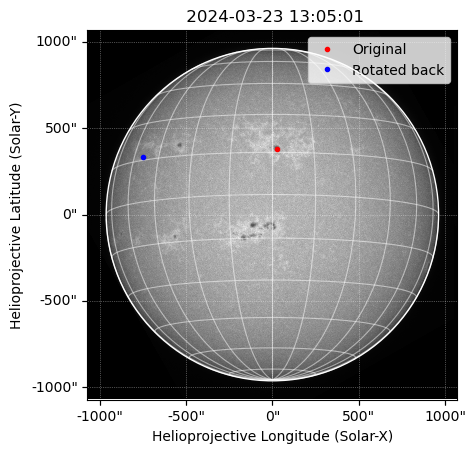

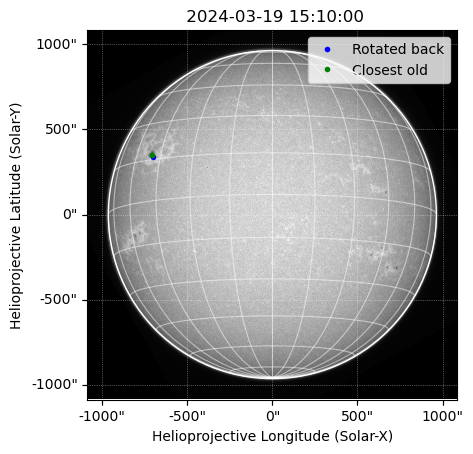

In [28]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection=map_new)
map_new.plot(axes=ax)
map_new.draw_limb(axes=ax)
map_new.draw_grid(axes=ax)
ax.plot_coord(point, 'r.', fillstyle='full', label='Original')
ax.plot_coord(transformed_diffrot_point, 'b.', fillstyle='full', label='Rotated back')
ax.legend(loc='upper right')

plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection=map_old)
map_old.plot(axes=ax)
map_old.draw_limb(axes=ax)
map_old.draw_grid(axes=ax)
ax.plot_coord(transformed_diffrot_point, 'b.', fillstyle='full', label='Rotated back')
ax.plot_coord(closest_point, 'g.', fillstyle='full', label='Closest old')
ax.legend(loc='upper right')

plt.show()

## Identifiers

Sunspots:
- datetime
- umbra
- penumbra
- centroids (labeled 1:end)
- identifiers (NOAA if available)

NOAA data